<a href="https://colab.research.google.com/github/Mvb-DL/LSTM-TEXTGEN/blob/main/CODE_MSUA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import os
import numpy as np
import keras
from datetime import datetime
from packaging import version
!pip install matplotlib
from matplotlib import pyplot as plt
!pip install livelossplot 
from livelossplot import PlotLossesKeras

# **Text von dem gelernt wird!**

In [ ]:
path_to_file = "the canterville ghost.txt" 
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')

# **Aufteilung in einzelne Sequenzen**

In [ ]:
vocab = sorted(set(text))
charidx = {u:i for i, u in enumerate(vocab)}
idxchar = np.array(vocab)

def text_to_int(text):
  return np.array([charidx[c] for c in text])

text_as_int = text_to_int(text)

def int_to_text(ints):
  try:
    ints = ints.numpy() 
  except:
    pass
  return ''.join(idxchar[ints]) 

seq_length = 200 
examples_per_epoch = len(text)//(seq_length+1)

char_dataset = tf.data.Dataset.from_tensor_slices(text_as_int)

In [ ]:
sequences = char_dataset.batch(seq_length+1, drop_remainder=True) 

In [ ]:
def split_input_target(chunk):  
    input_text = chunk[:-1]  
    target_text = chunk[1:]  
    return input_text, target_text  
dataset = sequences.map(split_input_target)  

# **Parameter werden definiert**

In [ ]:
BATCH_SIZE = 64 
VOCAB_SIZE = len(vocab) 
EMBEDDING_DIM = 256
RNN_UNITS = 1024
epochs = 120
 
BUFFER_SIZE = len(text) 
data = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

# **Zwischenspeicher des Modells "Savepoints"**

In [ ]:
logdir = "logs/scalars/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=logdir) 

# **Das Modell**

In [ ]:
def build_model(vocab_size, embedding_dim, rnn_units, batch_size):
  model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim,       
                              batch_input_shape=[batch_size, None]),
    tf.keras.layers.LSTM(rnn_units,                           
                        activation='tanh', 
                        recurrent_activation='sigmoid',
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform', 
                        go_backwards=False, 
                        dropout=0.0,
                        recurrent_dropout=0.0,
                        unroll=False,                    
                        ),
      tf.keras.layers.LSTM(rnn_units,                            
                        activation='tanh', 
                        recurrent_activation='sigmoid', 
                        return_sequences=True,
                        stateful=True,
                        recurrent_initializer='glorot_uniform', 
                        go_backwards=False, 
                        dropout=0.0,
                        recurrent_dropout=0.0,
                        unroll=False,                  
                        ),     
    tf.keras.layers.Dense(vocab_size)                         
  ])
  return model
model = build_model(VOCAB_SIZE,EMBEDDING_DIM, RNN_UNITS, BATCH_SIZE )  
model.summary()

In [ ]:
for input_example_batch, target_example_batch in data.take(1):
  example_batch_predictions = model(input_example_batch)

# **Bewertung des Modells**

In [ ]:
def loss(labels, logits): 
  return tf.keras.losses.sparse_categorical_crossentropy(labels, logits, from_logits=True)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
metrics = tf.keras.metrics.SparseCategoricalAccuracy()

model.compile(optimizer=optimizer, loss=loss, metrics= metrics)

# **Aktualisierung und Speichern der Savepoints**

In [ ]:
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

live_callback = PlotLossesKeras()

# **Liveübertragung des Trainings**

In [ ]:
checkpoint_dir = './training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback= tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

live_callback = PlotLossesKeras()

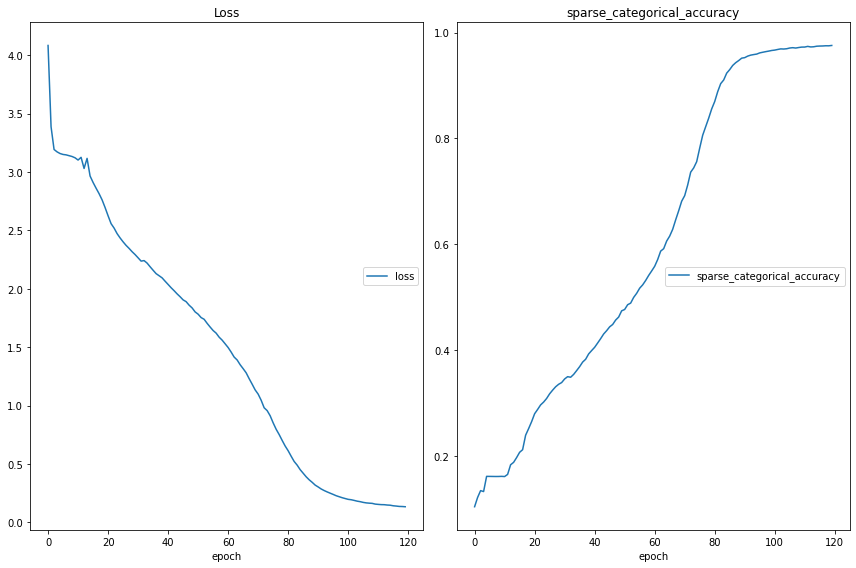

Loss
	loss             	 (min:    0.134, max:    4.083, cur:    0.134)
sparse_categorical_accuracy
	sparse_categorical_accuracy 	 (min:    0.105, max:    0.976, cur:    0.976)
5/5 [==============================] - 3s 265ms/step - loss: 0.1304 - sparse_categorical_accuracy: 0.9764
CPU times: user 4min 54s, sys: 48.3 s, total: 5min 42s
Wall time: 10min 4s


In [ ]:
%%time
history = model.fit(data, epochs=epochs, callbacks=[checkpoint_callback, live_callback])
results = model.evaluate(data)

# **Zusammenfassung und Endbewertung des Modells**

Test loss: 0.13037756085395813 / Test accuracy: 0.9764218926429749


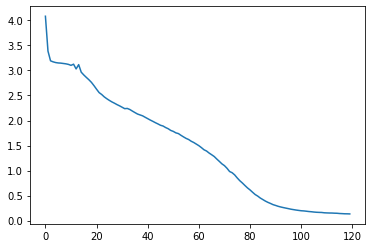

In [ ]:
print(f'Test loss: {results[0]} / Test accuracy: {results[1]}')
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

# **Speichern des Modells**

In [ ]:
model = build_model(VOCAB_SIZE, EMBEDDING_DIM, RNN_UNITS, batch_size=1)
model.load_weights(tf.train.latest_checkpoint(checkpoint_dir))
model.build(tf.TensorShape([1, None])) 

# **Textgenerator**

In [ ]:
def generate_text(model, start_string):
 
  num_generate = 2000

  input_eval = [charidx[s] for s in start_string]
  input_eval = tf.expand_dims(input_eval, 0)

  text_generated = []

  temperature = 1.0
 
  model.reset_states()
  for i in range(num_generate):
      predictions = model(input_eval)
    
      predictions = tf.squeeze(predictions, 0)

      predictions = predictions / temperature
      predicted_id = tf.random.categorical(predictions, num_samples=1)[-1,0].numpy()

      input_eval = tf.expand_dims([predicted_id], 0)

      text_generated.append(idxchar[predicted_id])

  return (start_string + ''.join(text_generated))

In [ ]:
inp = input("Gib einen Text ein: ")
print(generate_text(model, inp))